### Import libraries

In [1]:
%matplotlib inline

import os
import cv2
import json
import time
import math
import glob
import random
import numpy as np
from colorama import Fore
from matplotlib import cm
import matplotlib.pyplot as plt

### Global constant

In [2]:
# Generation
FIGURE_TYPES_NAMES = [
    'circle',
    'triangle',
    'quad',
    'pentagon'
]

MAX_FIGURES_COUNT = 19
IMAGE_SIZE = (512, 512)
FIGURES_GEN_EXCESS = 50
DISTANCE_SEPARATOR = 0.9
FIGURES_BOUNDARIES = (0.1, 0.9)
FIGURES_SPHERE_BOX_RADIUS = (0.025, 0.075)
FIGURES_SHAPES = (0,) + tuple(range(3, 6))
FIGURES_SHAPES_COUNT = len(FIGURES_SHAPES)


#Network

BATCH_SIZE = 8
STEPS_PER_EPOCH = 16
EPOCH_COUNT = 1 << 20

### Global model constants

In [3]:
#Encoder variables
MODEL_ENCODER_DROPOUT = 0.15
MODEL_ENCODER_POOLING = 'max'
MODEL_ENCODER_BRANCHES = (3, 7)
MODEL_ENCODER_ACTIVATION = 'tanh'
MODEL_ENCODER_LAYERS = (32, 64, 128)

#Decoder variables
MODEL_DECODER_DROPOUT = 0.15
MODEL_DECODER_BRANCHES = (3, 7)
MODEL_DECODER_ACTIVATION = 'tanh'
MODEL_DECODER_LAYERS = (128, 64, 32)

# Model variables
MODEL_INPUT_SHAPE = IMAGE_SIZE[::-1] + (1, )
MODEL_TENSORBOARD_DIR = 'train/MultiSemSeg'
MODEL_WEIGHTS_PATH = 'MultiClassSegmentation.dev'

### Generate figures

In [4]:
def DrawPolygon(image, circle, sides):
    """Draws a polygon inscribed in the circle
    """
    
    (x, y), r = circle
    astep = 2*math.pi/sides
    alpha = 2*math.pi*random.random()
    points = np.array([(x + r*math.cos(alpha + astep*i), \
    y + r*math.sin(alpha + astep*i)) for i in range(sides)], np.int32)

    cv2.fillConvexPoly(image, points, 255)

def CircleCollides(c1, c2):
    """Checks whether or not 2 circles collides"""
    
    (x1, y1), r1 = c1
    (x2, y2), r2 = c2
    return (x1-x2)**2 + (y1-y2)**2 < (DISTANCE_SEPARATOR*(r1+r2))**2


def Collides(sbb, circle):
    """Checks whether or not circle collides with any in the list
    """

    for c in sbb:
        if CircleCollides(c, circle):
            return True

    return False


DrawMap = [
    lambda image, circle: cv2.circle(image, circle[0], circle[1], 255, -1),
    lambda image, circle: DrawPolygon(image, circle, 3),
    lambda image, circle: DrawPolygon(image, circle, 4),
    lambda image, circle: DrawPolygon(image, circle, 5)
]


def GetPossibleDistributions(n, k):
    """
        Get possible distributions for up to
        n-1 amount of figures and k figures types
    """
    
    stack = []

    def Recursion(l, s, v):
        """
            Recursion function
            @param l Recursion depth
            @param s Sum so far
            @param v Current item
        """

        if l > 0:
            for i in range(0, n-s):
                Recursion(l-1, s + i, v + [i,])
        else:
            stack.append(v)
            
        return stack

    return np.array(Recursion(k, 0, []), np.uint32)


def DrawDistribution(distro):
  """
      Draws a sample given its distribution
      @param distro
  """

  sbb = []
  w, h = IMAGE_SIZE
  shapes = sum(distro)
  dd = (w*w + h*h)**0.5
  bb, ub = FIGURES_BOUNDARIES
  ngen = shapes*FIGURES_GEN_EXCESS
  rbb, rub = FIGURES_SPHERE_BOX_RADIUS
  image = np.zeros(IMAGE_SIZE[::-1] + (FIGURES_SHAPES_COUNT, ), np.uint8)

  while len(sbb) < shapes:
    radius = np.random.uniform(int(rbb*dd), int(rub*dd), \
                   ngen).astype(np.uint16).tolist()

    coords = np.random.uniform((int(bb*w), int(bb*h)), \
    (int(ub*w), int(ub*h)), (ngen, 2)).astype(np.uint16).tolist()

    for i in range(ngen):

      r = radius[i]
      p = tuple(coords[i])

      circle = (p, r)
      if not Collides(sbb, (p, r)):
        sbb.append(circle)

        if len(sbb) >= shapes:
            break

  count = 0
  for i in range(FIGURES_SHAPES_COUNT):
    draw = DrawMap[i]
    dst = np.zeros(IMAGE_SIZE[::-1], np.uint8)
    for j in range(distro[i]):
      draw(dst, sbb[count])
      count+=1

    image[:,:,i] = dst

  return image

In [5]:
SHAPES_DISTRIBUTIONS = GetPossibleDistributions(MAX_FIGURES_COUNT + 1, FIGURES_SHAPES_COUNT)

### Networks utilities

In [6]:
def KernelInitializer(seed=None):
    """
    Initializer with uniform distribution [-limit, limit] where limit = 1 / sqrt(fan_in)
    :param seed Initializer seed. If None is passed a random seed will be taken
    :return: A kernel initializer as of description says
    """

    from keras.initializers import VarianceScaling

    return VarianceScaling(scale=1./3.,
                           mode='fan_in',
                           distribution='uniform',
                           seed=seed)


def BnAffine(name=None, axis=-1):
    """
    Returns affine BN layer over last_channel
    :param name: Layer name
    :param axis: Which axis to perform BN over
    :return: Custom adjusted BN affine layer
    """

    from keras.layers import BatchNormalization
    from keras.initializers import RandomUniform

    return BatchNormalization(momentum=0.1, epsilon=1e-5,
    gamma_initializer=RandomUniform(0, 1), axis=axis, name=name)


def SqrConv2D(neurons, ksize, activation=None, name=None):
    """
    Square kernel 2D convolution
    :param neurons: Number of convolution channels
    :param ksize: Convolution kernel size
    :param activation: Layer activation. If None is passed, it will use no activation
    :param name: Layer name
    :return: Custom adjusted 2D square convolutional layer 
    """

    from keras.layers import Conv2D

    return Conv2D(neurons, (ksize, ksize), kernel_initializer=KernelInitializer(),
    bias_initializer=KernelInitializer(), padding='same', activation=activation, name=name)

### Build encoder model

In [7]:
def EncoderResBlock(layers):
    """
        Makes residual operation for image model
    """
    
    import tensorflow as tf

    inp = layers[0]
    concat = tf.concat(layers[1:], -1)
    mult = int(concat.shape[-1]) // int(inp.shape[-1])

    return concat + tf.tile(inp, [1, 1, 1, mult])


def DefineModelEncoder(shape,
                       pool=MODEL_ENCODER_POOLING,
                       layers=MODEL_ENCODER_LAYERS,
                       branches=MODEL_ENCODER_BRANCHES,
                       actfn=MODEL_ENCODER_ACTIVATION,
                       dropout=MODEL_ENCODER_DROPOUT,
                       name='encoder'):
    """
    Defines model encoder
    :param shape: Input shape
    :param pool: Pooling method: avg or max
    :param actfn: Activation function
    :param dropout Dropout percentage
    :param name Model block name
    """

    from keras.models import Model
    from keras.layers import Input, Lambda, Concatenate, \
        Dropout, MaxPooling2D, AveragePooling2D, Activation

    x = inp = Input(shape=shape, name='%s_input' % name)
    Pooling2D = MaxPooling2D if pool == 'max' else AveragePooling2D
    
    for i, neurons in enumerate(layers):

        pnames = (name, i)
        btensors = [SqrConv2D(neurons, k, 
        name='%s_block%u_branch%ux%u' % (pnames + (k, k)))(x) for k in branches]
        
        if i:
            concat = Lambda(EncoderResBlock, name='%s_block%u_concat' % pnames)([x,] + btensors)
        else:
            concat = Concatenate(name='%s_block%u_concat' % pnames)(btensors)

        bn = BnAffine(name='%s_block%u_bn' % pnames)(concat)
        activation = Activation(actfn, name='%s_block%u_activation' % pnames)(bn)
        pool = Pooling2D(name='%s_block%u_pool' % pnames)(activation)
        x = Dropout(dropout, name='%s_block%u_dropout' % pnames)(pool)

    return Model(inputs=inp, outputs=x, name=name)

### Build decoder model

In [8]:
def DecoderResBlock(layers):
    """
        Makes residual operation for image model
    """
    
    import tensorflow as tf

    inp = layers[0]
    concat = tf.concat(layers[1:], -1)
    mult = int(inp.shape[-1]) // int(concat.shape[-1])
    residual = tf.add_n([inp[:,:,:, i::mult] \
                   for i in range(mult)]) / float(mult)

    return concat + residual


def DefineModelDecoder(shape,
                       layers=MODEL_DECODER_LAYERS,
                       branches=MODEL_DECODER_BRANCHES,
                       actfn=MODEL_DECODER_ACTIVATION,
                       dropout=MODEL_DECODER_DROPOUT,
                       name='decoder'):
    """
    Defines model decoder
    :param shape: Input shape
    :param actfn: Activation function
    :param dropout Dropout percentage
    :param name Model block name
    """

    from keras.models import Model
    from keras.layers import Input, Lambda, Reshape, UpSampling2D, Dropout, \
                                                  TimeDistributed, Activation

    x = inp = Input(shape=shape, name='%s_input' % name)
    
    for i, neurons in enumerate(layers):

        pnames = (name, i)
        btensors = [SqrConv2D(neurons, k, 
        name='%s_block%u_branch%ux%u' % (pnames + (k, k)))(x) for k in branches]
        concat = Lambda(DecoderResBlock, name='%s_block%u_concat' % pnames)([x,] + btensors)

        bn = BnAffine(name='%s_block%u_bn' % pnames)(concat)
        activation = Activation(actfn, name='%s_block%u_activation' % pnames)(bn)
        pool = UpSampling2D(name='%s_block%u_pool' % pnames)(activation)
        x = Dropout(dropout, name='%s_block%u_dropout' % pnames)(pool)

    pnames = (name, i+1)
    x = SqrConv2D(FIGURES_SHAPES_COUNT + 1, 3, name='%s_block%u_branch3x3' % pnames)(x)
    x = BnAffine(name='%s_block%u_bn' % pnames)(x)
    x = Activation('sigmoid', name='%s_block%u_activation' % pnames)(x)

    return Model(inputs=inp, outputs=x, name=name)

### Define the model

In [9]:
def DefineModel(name='segmentation'):
    """
    Segmentation model
    """
    
    from keras.models import Model
    from keras.layers import Input
    from keras.optimizers import Adadelta
    
    inp = Input(shape=MODEL_INPUT_SHAPE, name='%s_input' % name)
    
    encoder = DefineModelEncoder(MODEL_INPUT_SHAPE)
    decoder = DefineModelDecoder(encoder.output_shape[1:])

    opt = Adadelta(lr=2e-1, decay=1e-6, rho=0.9)
    model = Model(inputs=inp, outputs=decoder(encoder(inp)), name=name)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    
    return model

### Load the model

In [10]:
model = DefineModel()
model.summary()

try:
    print('[INFO] Trying to load model weights...')
    model.load_weights(MODEL_WEIGHTS_PATH)
    print('[INFO] Successfully loaded model weights.')
except Exception as e:
    print('[ERROR] Failure while loading the model weights.')
    print(e)
    

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
segmentation_input (InputLay (None, 512, 512, 1)       0         
_________________________________________________________________
encoder (Model)              (None, 64, 64, 256)       1191936   
_________________________________________________________________
decoder (Model)              (None, 512, 512, 5)       3093529   
Total params: 4,285,465
Trainable params: 4,283,663
Non-trainable params: 1,802
_________________________________________________________________
[INFO] Trying to load model weights...
[ERROR] Failure while loading the model weights.
Unable to open file (unable to open file: name = 'MultiClassSegmentation.dev', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Define callbacks

In [11]:
def LoadCallbacks(init_epoch = 0):
  """
  Loads callbacks
  """
  
  from keras.callbacks import Callback, TensorBoard

  class MetricCallback(Callback):

    def on_epoch_end(self, epoch, logs={}):

      if (epoch & 15) != 0:
        return

      X, Y = next(Generator(10))
      print()
      print('Metric: ' + str(np.linalg.norm(model.predict(X)-Y)))
      print()


  class EpochCallback(Callback):

    def __init__(self, epoch=0):
      Callback.__init__(self)
      self.epoch = epoch


    def on_epoch_end(self, epoch, logs={}):
      self.epoch = epoch

      
  return [EpochCallback(init_epoch), TensorBoard(log_dir = MODEL_TENSORBOARD_DIR), MetricCallback()]

### Define generator

In [12]:
def Generator(batchsize, testing=False):

  X = np.zeros((batchsize, ) + IMAGE_SIZE[::-1] + (1,), np.float32)
  Y = np.zeros((batchsize, ) + IMAGE_SIZE[::-1] + (FIGURES_SHAPES_COUNT + 1, ), np.float32)

  while True:

    # Generate negative samples
    for i in range(batchsize):
      img = np.zeros(IMAGE_SIZE[::-1] + (1,), np.uint8)
      distro = random.choice(SHAPES_DISTRIBUTIONS)
      mask = DrawDistribution(distro)

      for j in range(FIGURES_SHAPES_COUNT):
        img|=mask[:,:,j:j+1]

      X[i] = img
      Y[i] = np.concatenate((mask, ~img), axis=-1)

    yield (X, Y) if testing else (X/255., Y/255.)

### Initialize train variables

In [13]:
callbacks = LoadCallbacks(0)

In [14]:
train_generator = Generator(BATCH_SIZE)

### Train model

In [ ]:
model.fit_generator(train_generator,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = EPOCH_COUNT,
                verbose = 1,
                initial_epoch = callbacks[0].epoch,
                callbacks=callbacks
         )

Epoch 1517/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0052 - acc: 0.9989
Epoch 1518/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0050 - acc: 0.9990
Epoch 1519/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0052 - acc: 0.9989
Epoch 1520/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0049 - acc: 0.9990
Epoch 1521/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0054 - acc: 0.9989

Metric: 85.8413

Epoch 1522/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0051 - acc: 0.9990
Epoch 1523/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0050 - acc: 0.9990
Epoch 1524/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0050 - acc: 0.9990
Epoch 1525/1048576
16/16 [==============================] - 50s 3s/step - loss: 0.0056 - acc: 0.9989
Epoch 1526/1048576
16/16 [==============================] - 50s 3s/step -

In [ ]:
model.save_weights(MODEL_WEIGHTS_PATH)

### Test the model

In [16]:
cmap = cm.get_cmap('jet')
test_generator = Generator(16, testing=True)
ymask = np.zeros(IMAGE_SIZE[::-1] + (3,), np.uint8)
ymaskpred = np.zeros(IMAGE_SIZE[::-1] + (3,), np.uint8)
colors = np.array([cmap(float(i)/FIGURES_SHAPES_COUNT)[:3] \
                          for i in range(FIGURES_SHAPES_COUNT+1)])

[INFO] Time delta is 2.4120


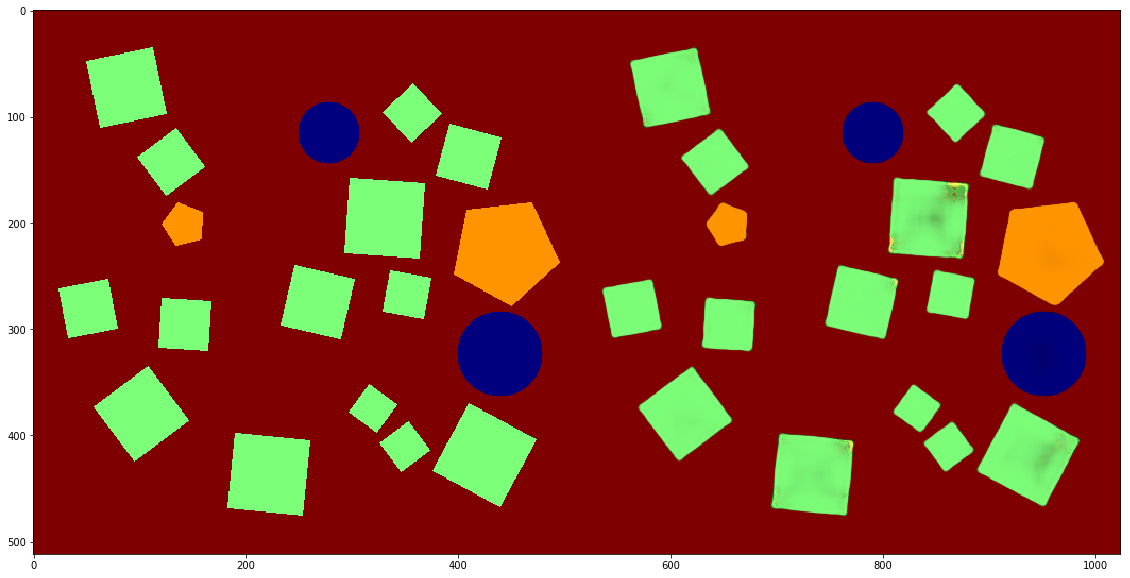

--------------------------------------------------------------------------------------------------------------------


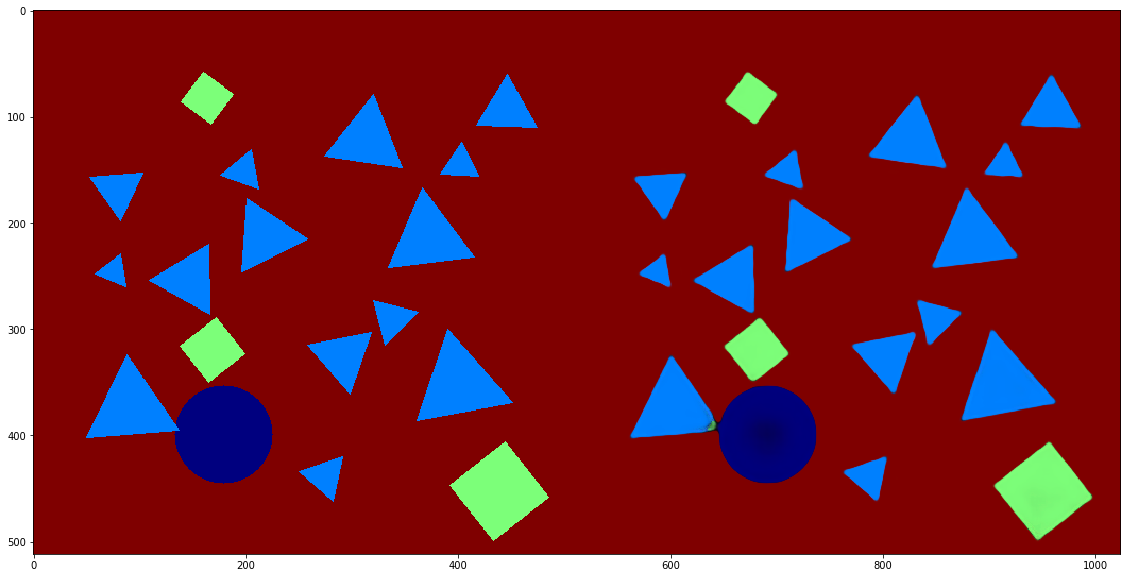

--------------------------------------------------------------------------------------------------------------------


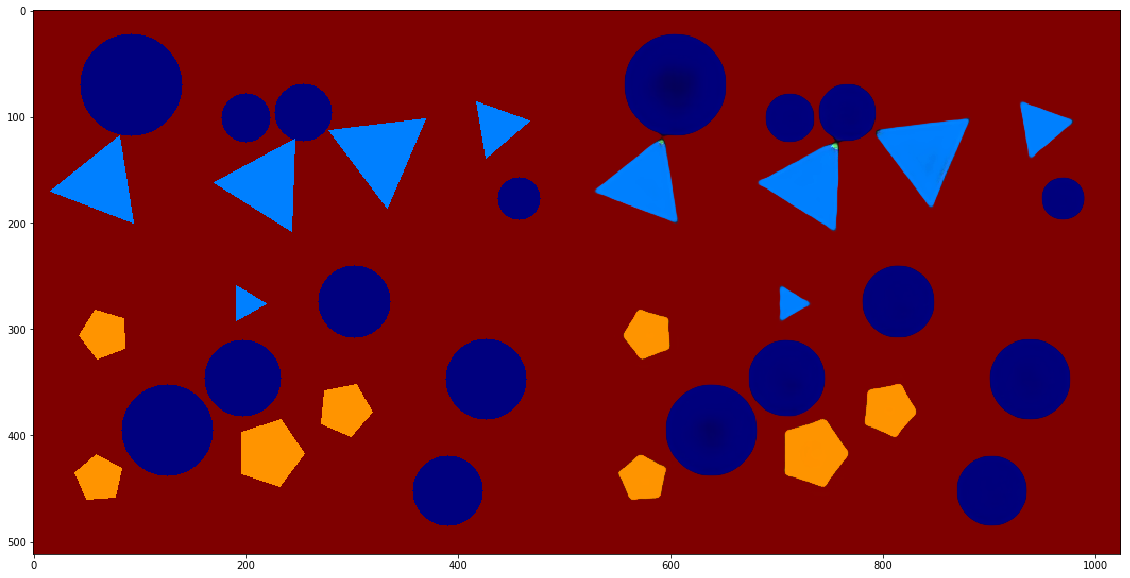

--------------------------------------------------------------------------------------------------------------------


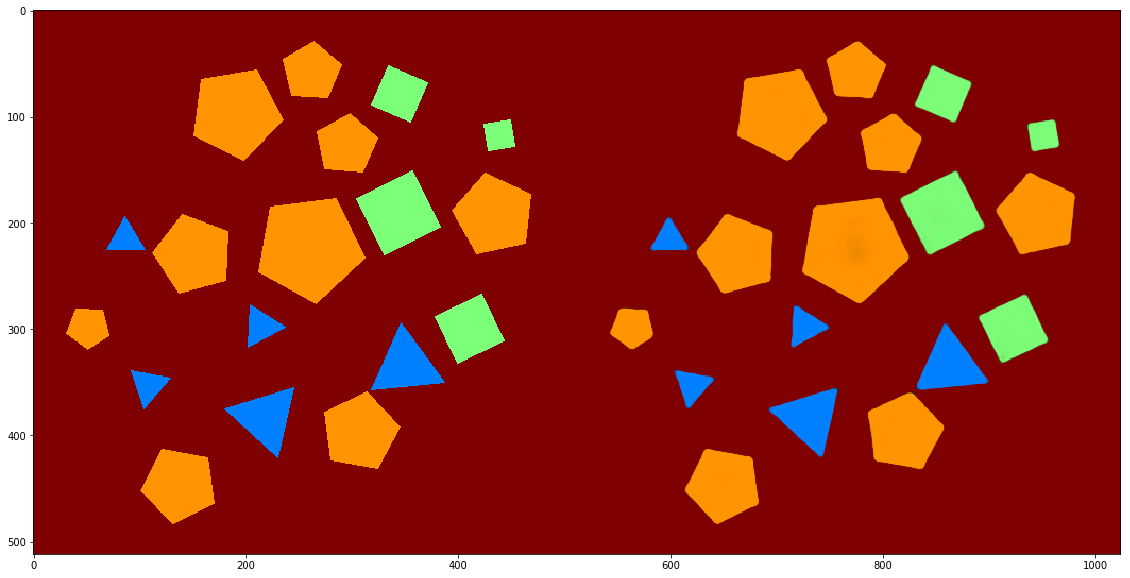

--------------------------------------------------------------------------------------------------------------------


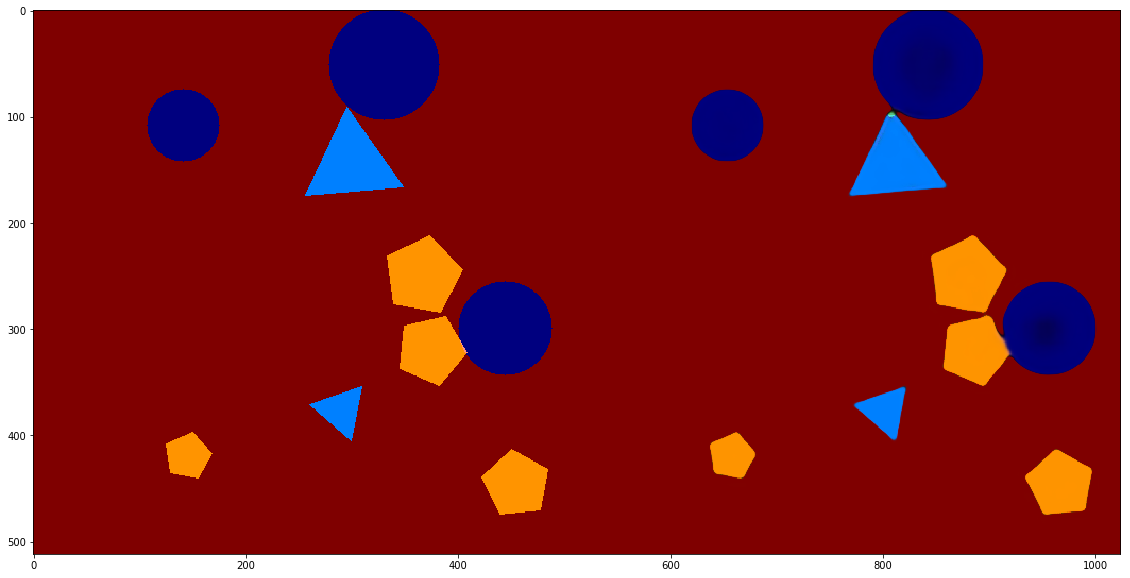

--------------------------------------------------------------------------------------------------------------------


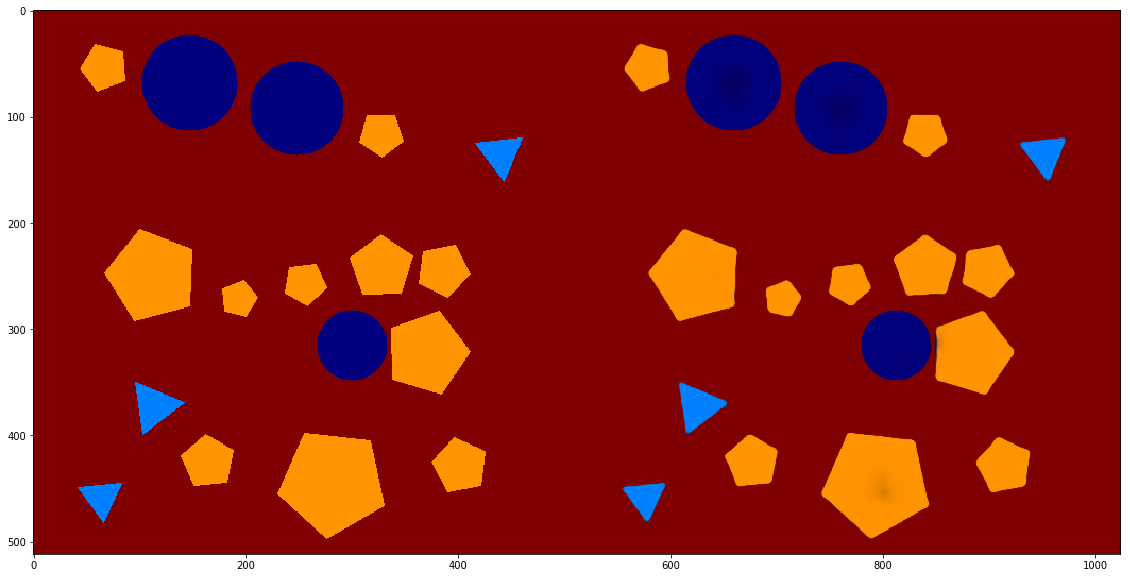

--------------------------------------------------------------------------------------------------------------------


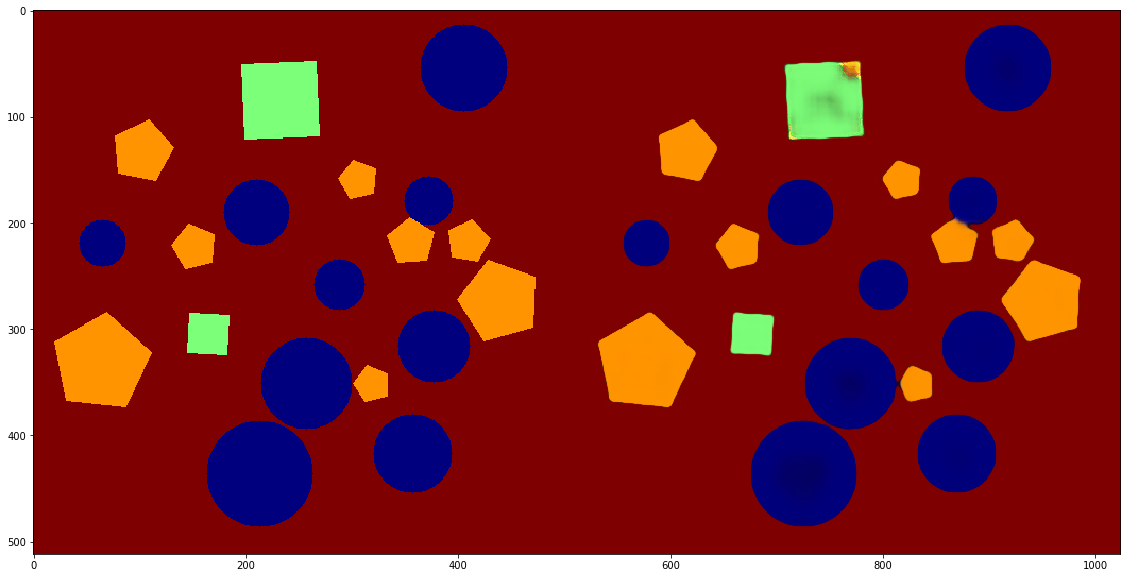

--------------------------------------------------------------------------------------------------------------------


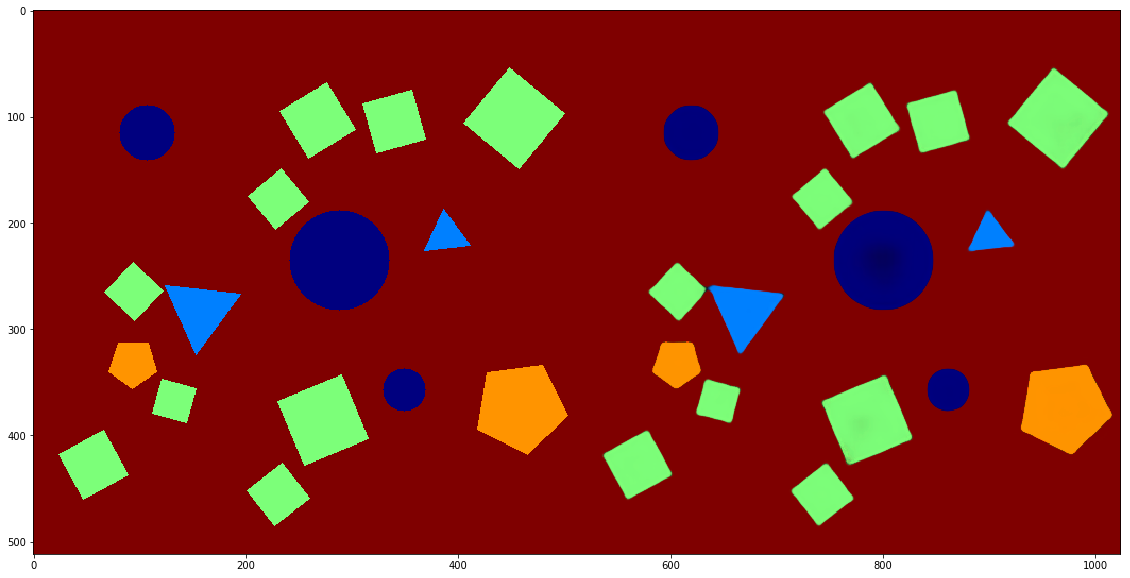

--------------------------------------------------------------------------------------------------------------------


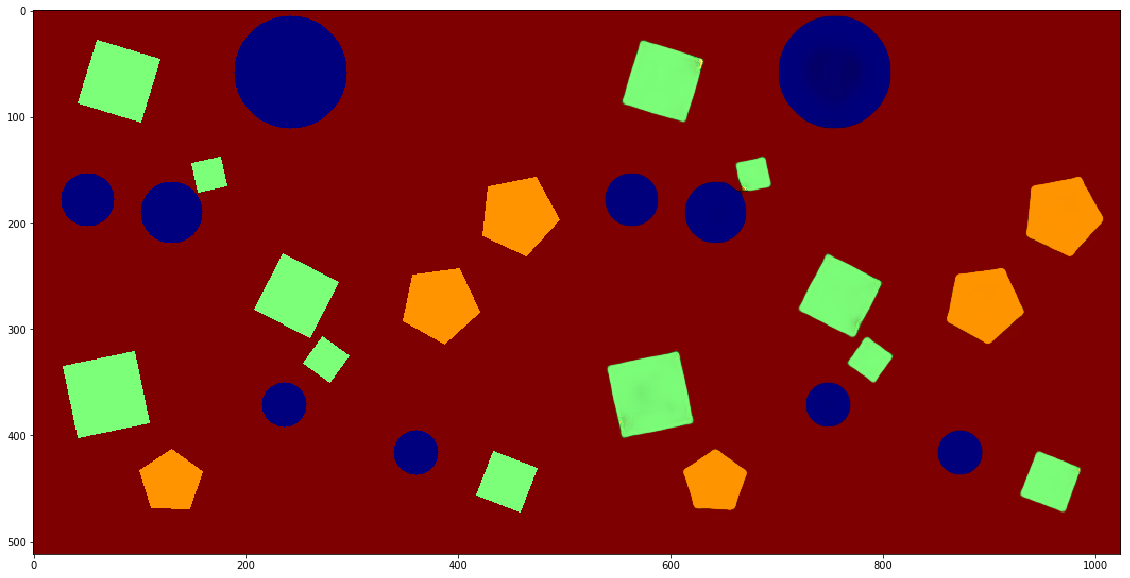

--------------------------------------------------------------------------------------------------------------------


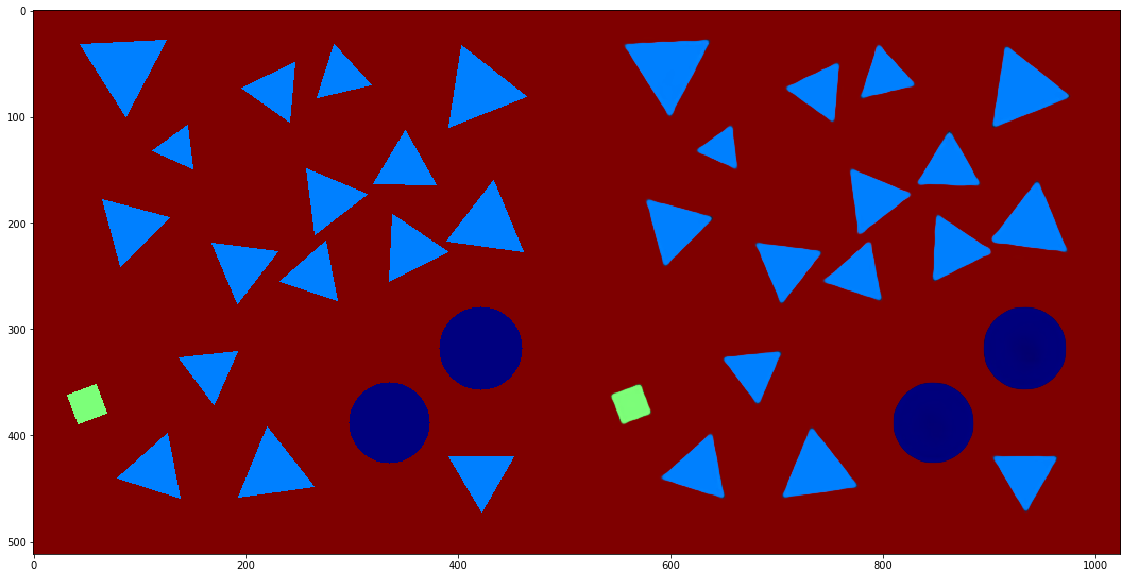

--------------------------------------------------------------------------------------------------------------------


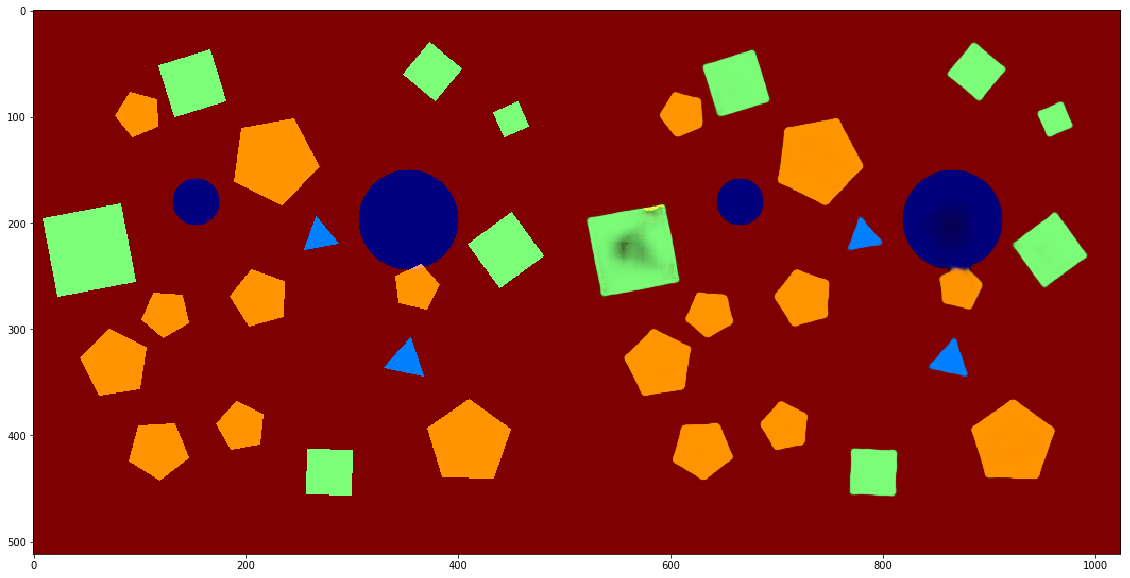

--------------------------------------------------------------------------------------------------------------------


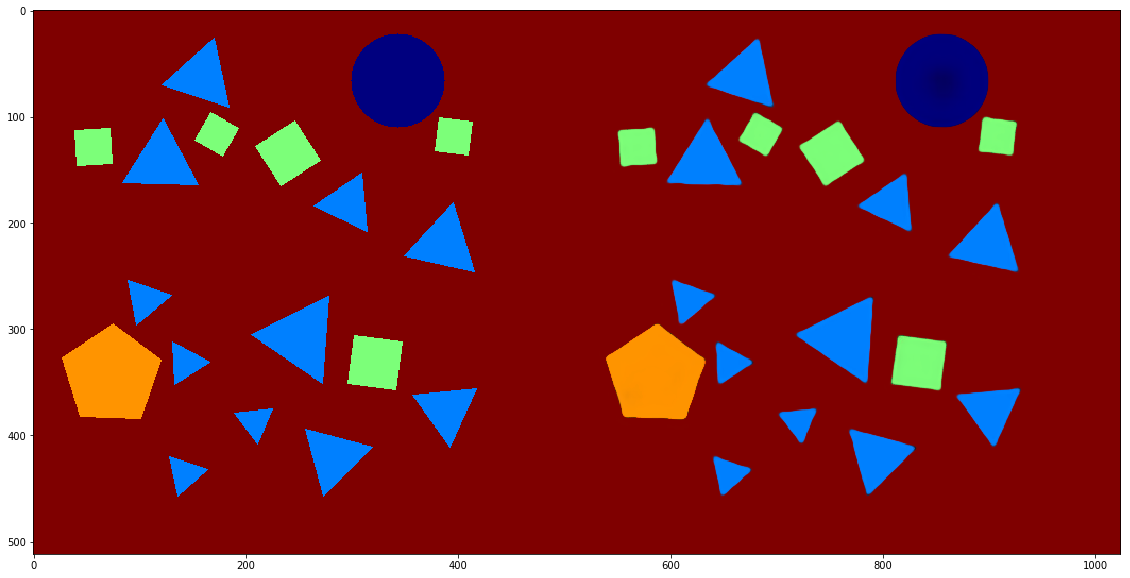

--------------------------------------------------------------------------------------------------------------------


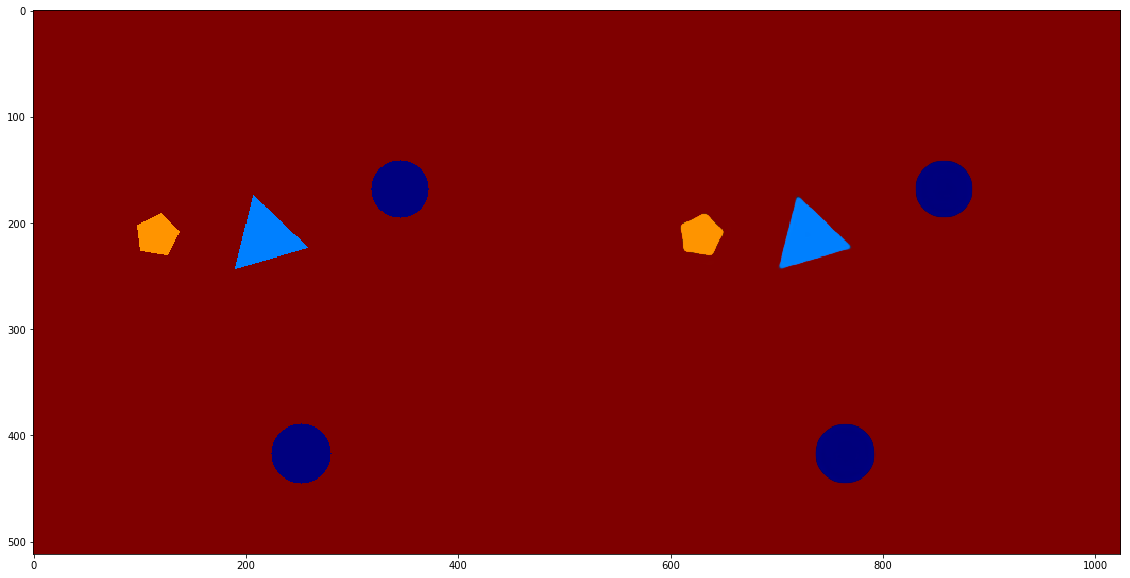

--------------------------------------------------------------------------------------------------------------------


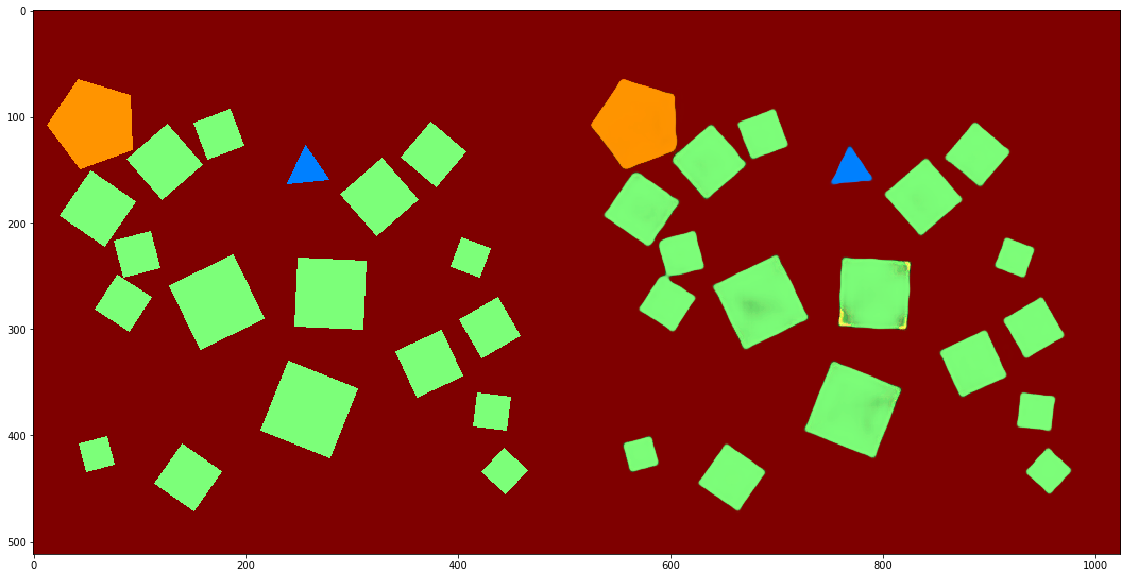

--------------------------------------------------------------------------------------------------------------------


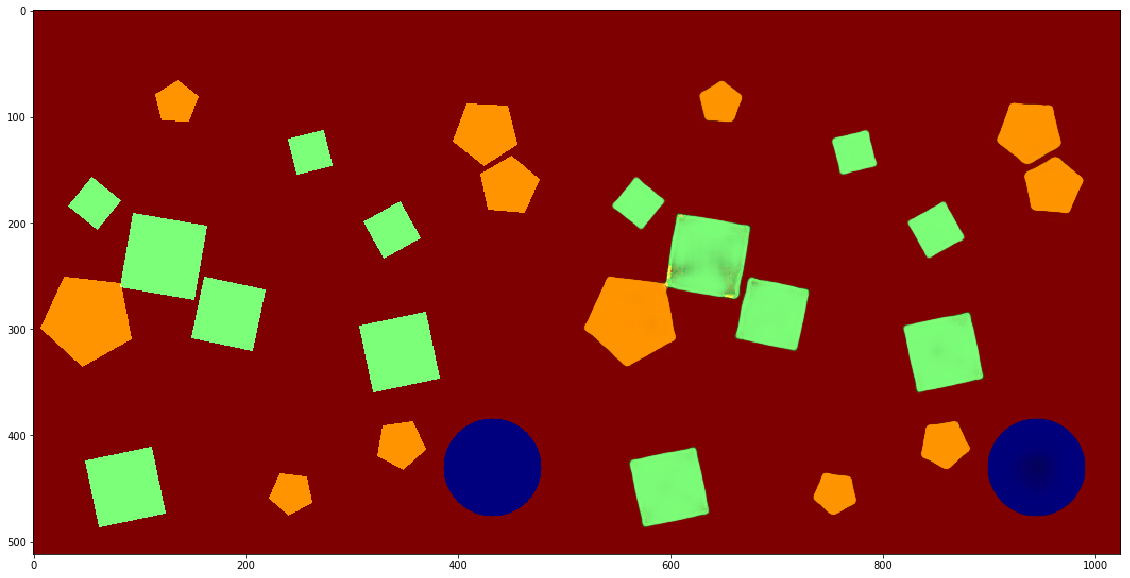

--------------------------------------------------------------------------------------------------------------------


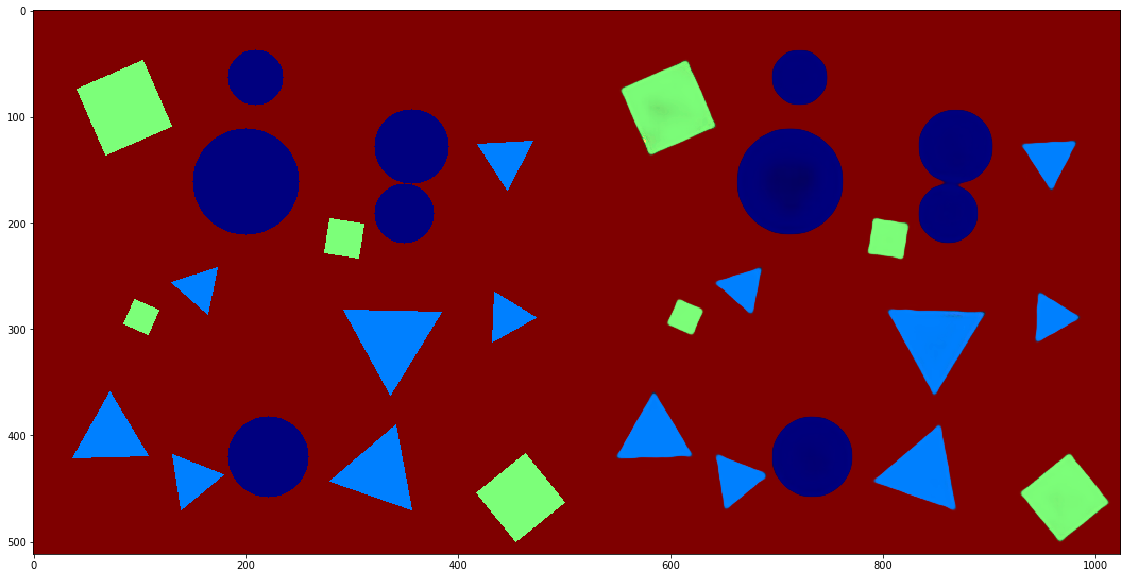

--------------------------------------------------------------------------------------------------------------------


In [23]:
X, Y = next(test_generator)

t0 = time.time()
Ypred = 255.*model.predict(X/255.)
t1 = time.time()

print('[INFO] Time delta is %.4f' % (t1 - t0, ))

for i in range(Ypred.shape[0]):
  x, y, ypred, ymask, ymaskpred = X[i,:,:,0], Y[i], Ypred[i], 0, 0

  for j in range(FIGURES_SHAPES_COUNT+1):
    color = colors[j]
    ymask|=(color*y[:,:,j:j+1]).astype(np.uint8)
    ymaskpred|=(color*ypred[:,:,j:j+1]).astype(np.uint8)

  plt.figure(figsize=(20, 10))
  plt.imshow(np.hstack((ymask, ymaskpred)))
  plt.show()
  plt.clf()

  print(Fore.RED + '-' * 116)